# 05 — Modeling

Binary classification: predict whether TSLA closes **higher** the next trading day.

| Model | Type | Data |
|-------|------|------|
| Logistic Regression | Linear baseline | Scaled |
| Random Forest | Ensemble (bagging) | Unscaled |
| XGBoost | Ensemble (boosting) | Unscaled |
| Neural Net (MLP) | Deep learning | Scaled |

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay)
from src.helpers import DATA_PROCESSED

sns.set_theme(style='whitegrid')
SEED = 42

## 1. Data & Train/Test Split

Temporal split at **2024-01-01** — no random shuffle, no future data in training.

In [2]:
df = pd.read_csv(DATA_PROCESSED / 'features_ready.csv', index_col='Date', parse_dates=True).sort_index()

drop_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'target']
feature_cols = [c for c in df.columns if c not in drop_cols]
X, y = df[feature_cols], df['target'].astype(int)

SPLIT = '2024-01-01'
X_train, X_test = X[df.index < SPLIT], X[df.index >= SPLIT]
y_train, y_test = y[df.index < SPLIT], y[df.index >= SPLIT]

scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=feature_cols)
X_test_s = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=feature_cols)

print(f'Features: {len(feature_cols)}  |  Train: {len(X_train)} rows  |  Test: {len(X_test)} rows')
print(f'Train: {X_train.index.min().date()} to {X_train.index.max().date()}  |  target balance: {y_train.mean():.1%}')
print(f'Test:  {X_test.index.min().date()} to {X_test.index.max().date()}  |  target balance: {y_test.mean():.1%}')

Features: 25  |  Train: 2011 rows  |  Test: 535 rows
Train: 2016-01-05 to 2023-12-29  |  target balance: 52.2%
Test:  2024-01-02 to 2026-02-19  |  target balance: 50.1%


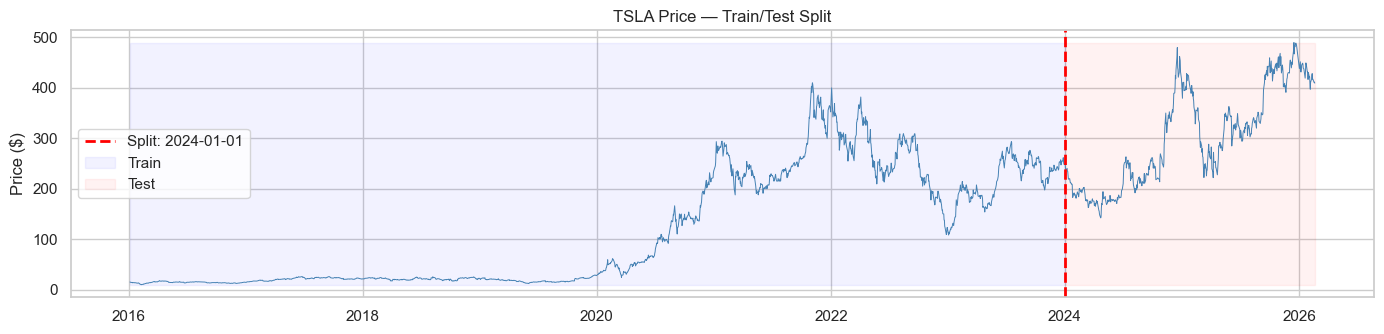

In [3]:
fig, ax = plt.subplots(figsize=(14, 3.5))
ax.plot(df.index, df['Close'], lw=0.7, color='steelblue')
ax.axvline(pd.Timestamp(SPLIT), color='red', ls='--', lw=2, label=f'Split: {SPLIT}')
ax.fill_betweenx([df['Close'].min(), df['Close'].max()], df.index.min(), pd.Timestamp(SPLIT), alpha=0.05, color='blue', label='Train')
ax.fill_betweenx([df['Close'].min(), df['Close'].max()], pd.Timestamp(SPLIT), df.index.max(), alpha=0.05, color='red', label='Test')
ax.set_title('TSLA Price — Train/Test Split')
ax.set_ylabel('Price ($)')
ax.legend()
plt.tight_layout()
plt.show()

## 2. Model Training

All models use **TimeSeriesSplit (5 folds)** for cross-validation on the training set, then are evaluated on the held-out test set.

In [4]:
tscv = TimeSeriesSplit(n_splits=5)
SCORING = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=SEED, C=1.0), True),
    'Random Forest': (RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=20, random_state=SEED, n_jobs=-1), False),
    'XGBoost': (XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=SEED, eval_metric='logloss'), False),
    'Neural Net (MLP)': (MLPClassifier(hidden_layer_sizes=(64, 32), alpha=1e-4, batch_size=64, learning_rate_init=1e-3, max_iter=200, early_stopping=True, random_state=SEED, verbose=False), True),
}

cv_rows, test_rows = [], []
fitted, preds, probs = {}, {}, {}

for name, (model, scaled) in models.items():
    Xtr = X_train_s if scaled else X_train
    Xte = X_test_s if scaled else X_test

    # Cross-validation
    cv = cross_validate(model, Xtr, y_train, cv=tscv, scoring=SCORING, n_jobs=-1)
    cv_row = {'Model': name}
    for s in SCORING:
        cv_row[s] = f"{cv[f'test_{s}'].mean():.3f} +/- {cv[f'test_{s}'].std():.3f}"
    cv_rows.append(cv_row)

    # Fit on full train, evaluate on test
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    y_prob = model.predict_proba(Xte)[:, 1]

    fitted[name] = model
    preds[name] = y_pred
    probs[name] = y_prob

    test_rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_prob),
    })
    print(f'{name:25s}  acc={test_rows[-1]["Accuracy"]:.3f}  f1={test_rows[-1]["F1"]:.3f}  auc={test_rows[-1]["AUC"]:.3f}')

print(f'\nBaseline (always predict majority): {max(y_test.mean(), 1-y_test.mean()):.3f}')

test_df = pd.DataFrame(test_rows).set_index('Model')

Logistic Regression        acc=0.555  f1=0.417  auc=0.622
Random Forest              acc=0.579  f1=0.505  auc=0.635
XGBoost                    acc=0.564  f1=0.410  auc=0.626
Neural Net (MLP)           acc=0.570  f1=0.368  auc=0.637

Baseline (always predict majority): 0.501


## 3. Hyperparameter Tuning

Use **RandomizedSearchCV** with TimeSeriesSplit to find better hyperparameters for each model.

In [5]:
print('Default parameters used in Section 2:\n')
defaults = {
    'Logistic Regression': {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'},
    'Random Forest': {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 20},
    'XGBoost': {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8},
    'Neural Net (MLP)': {'hidden_layer_sizes': (64, 32), 'alpha': 1e-4, 'learning_rate_init': 1e-3, 'batch_size': 64},
}
for name, params in defaults.items():
    print(f'{name:25s}  {params}')

Default parameters used in Section 2:

Logistic Regression        {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Random Forest              {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 20}
XGBoost                    {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8}
Neural Net (MLP)           {'hidden_layer_sizes': (64, 32), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'batch_size': 64}


In [6]:
from sklearn.model_selection import RandomizedSearchCV

param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0], 'penalty': ['l1', 'l2'], 'solver': ['saga']},
    'Random Forest': {'n_estimators': [100, 200, 300, 500], 'max_depth': [5, 7, 10, 15, None], 'min_samples_leaf': [10, 20, 30, 50], 'max_features': ['sqrt', 'log2', 0.3, 0.5]},
    'XGBoost': {'n_estimators': [100, 200, 300, 500], 'max_depth': [3, 4, 5, 7], 'learning_rate': [0.01, 0.03, 0.05, 0.1], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 'reg_alpha': [0, 0.1, 0.5, 1.0], 'reg_lambda': [0.5, 1.0, 2.0]},
    'Neural Net (MLP)': {'hidden_layer_sizes': [(32,), (64, 32), (128, 64), (64, 32, 16)], 'alpha': [1e-5, 1e-4, 1e-3, 1e-2], 'learning_rate_init': [5e-4, 1e-3, 3e-3], 'batch_size': [32, 64, 128]},
}

base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=SEED),
    'Random Forest': RandomForestClassifier(random_state=SEED, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=SEED, eval_metric='logloss'),
    'Neural Net (MLP)': MLPClassifier(early_stopping=True, max_iter=200, random_state=SEED, verbose=False),
}

needs_scaling = {'Logistic Regression', 'Neural Net (MLP)'}
tuned_models = {}

for name in base_models:
    Xtr = X_train_s if name in needs_scaling else X_train
    search = RandomizedSearchCV(
        base_models[name], param_grids[name],
        n_iter=30, cv=tscv, scoring='roc_auc',
        random_state=SEED, n_jobs=-1, refit=True
    )
    search.fit(Xtr, y_train)
    tuned_models[name] = search.best_estimator_
    print(f'{name:25s}  best CV AUC={search.best_score_:.4f}')
    print(f'  params: {search.best_params_}')

Logistic Regression        best CV AUC=0.5714
  params: {'solver': 'saga', 'penalty': 'l1', 'C': 0.1}
Random Forest              best CV AUC=0.5552
  params: {'n_estimators': 500, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 15}
XGBoost                    best CV AUC=0.5639
  params: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
Neural Net (MLP)           best CV AUC=0.5602
  params: {'learning_rate_init': 0.003, 'hidden_layer_sizes': (128, 64), 'batch_size': 64, 'alpha': 0.0001}


## 3b. Optuna — XGBoost Deep Tuning

RandomizedSearchCV only tested 30 random combinations. Optuna uses Bayesian optimization (TPE) to intelligently search **1000 trials**, focusing on promising hyperparameter regions.

The search space is tightened vs the previous 200-trial run to reduce overfitting:
- `max_depth` capped at 7 (was 10) — with only ~2000 training rows, deeper trees overfit
- `min_child_weight` floor raised to 3 — forces larger leaf nodes
- Added `scale_pos_weight` to handle slight class imbalance

In [7]:
import optuna
from sklearn.model_selection import cross_val_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 30),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 1.2),
        'random_state': SEED,
        'eval_metric': 'logloss',
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
study.optimize(xgb_objective, n_trials=1000, show_progress_bar=True)

print(f'Best CV AUC: {study.best_value:.4f}')
print(f'Best params: {study.best_params}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Best CV AUC: 0.5789
Best params: {'n_estimators': 423, 'max_depth': 4, 'learning_rate': 0.09688311506751089, 'subsample': 0.5167799290855254, 'colsample_bytree': 0.9587231158150672, 'reg_alpha': 0.12554223852837357, 'reg_lambda': 1.5542570759773569, 'min_child_weight': 7, 'gamma': 0.18913486255944054, 'scale_pos_weight': 0.8221076432407406}


In [8]:
# Fit Optuna-tuned XGBoost and compare
xgb_optuna = XGBClassifier(**study.best_params, random_state=SEED, eval_metric='logloss')
xgb_optuna.fit(X_train, y_train)

y_pred_optuna = xgb_optuna.predict(X_test)
y_prob_optuna = xgb_optuna.predict_proba(X_test)[:, 1]

# Replace in tuned_models so downstream cells use it
tuned_models['XGBoost'] = xgb_optuna

# RandomSearch best params (from Section 3 above)
rs_params = {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
xgb_rs = XGBClassifier(**rs_params, random_state=SEED, eval_metric='logloss')
xgb_rs.fit(X_train, y_train)
y_pred_rs = xgb_rs.predict(X_test)
y_prob_rs = xgb_rs.predict_proba(X_test)[:, 1]

print('XGBoost — Test Set Comparison:')
print(f'  {"":20s} {"Accuracy":>10s} {"F1":>10s} {"AUC":>10s}')
print(f'  {"Default":20s} {accuracy_score(y_test, preds["XGBoost"]):10.4f} {f1_score(y_test, preds["XGBoost"]):10.4f} {roc_auc_score(y_test, probs["XGBoost"]):10.4f}')
print(f'  {"RandomSearch":20s} {accuracy_score(y_test, y_pred_rs):10.4f} {f1_score(y_test, y_pred_rs):10.4f} {roc_auc_score(y_test, y_prob_rs):10.4f}')
print(f'  {"Optuna (1000 trials)":20s} {accuracy_score(y_test, y_pred_optuna):10.4f} {f1_score(y_test, y_pred_optuna):10.4f} {roc_auc_score(y_test, y_prob_optuna):10.4f}')

XGBoost — Test Set Comparison:
                         Accuracy         F1        AUC
  Default                  0.5645     0.4101     0.6257
  RandomSearch             0.5664     0.4423     0.6265
  Optuna (1000 trials)     0.5346     0.3252     0.5921


## 3c. Optuna — Neural Net (MLP) Deep Tuning

sklearn's MLPClassifier is limited (no dropout layer), but we can still push it further by tuning:
- **Architecture**: number of layers (1–3) and width (16–256 neurons)
- **Regularization (alpha)**: L2 penalty — this is the MLP's main overfitting control
- **Learning rate & batch size**: affect convergence and generalization
- **Activation function**: relu vs tanh
- **max_iter**: allow longer training (up to 500 epochs with early stopping)

In [9]:
def mlp_objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 16, 256, log=True))
    
    params = {
        'hidden_layer_sizes': tuple(layers),
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'early_stopping': True,
        'max_iter': 500,
        'random_state': SEED,
        'verbose': False,
        'validation_fraction': 0.15,
        'n_iter_no_change': 15,
    }
    model = MLPClassifier(**params)
    scores = cross_val_score(model, X_train_s, y_train, cv=tscv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study_mlp = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_mlp.optimize(mlp_objective, n_trials=1000, show_progress_bar=True)

print(f'Best CV AUC: {study_mlp.best_value:.4f}')
print(f'Best params: {study_mlp.best_params}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Best CV AUC: 0.5819
Best params: {'n_layers': 2, 'n_units_l0': 170, 'n_units_l1': 29, 'alpha': 0.0005174503473175281, 'learning_rate_init': 0.000859519898265336, 'batch_size': 16, 'activation': 'relu'}


In [18]:
# Reconstruct best MLP architecture from Optuna params
best_mlp_params = study_mlp.best_params
n_layers = best_mlp_params['n_layers']
best_layers = tuple(best_mlp_params[f'n_units_l{i}'] for i in range(n_layers))

mlp_optuna = MLPClassifier(
    hidden_layer_sizes=best_layers,
    alpha=best_mlp_params['alpha'],
    learning_rate_init=best_mlp_params['learning_rate_init'],
    batch_size=best_mlp_params['batch_size'],
    activation=best_mlp_params['activation'],
    early_stopping=True, max_iter=500, random_state=SEED, verbose=False,
    validation_fraction=0.15, n_iter_no_change=15,
)
mlp_optuna.fit(X_train_s, y_train)

y_pred_mlp_optuna = mlp_optuna.predict(X_test_s)
y_prob_mlp_optuna = mlp_optuna.predict_proba(X_test_s)[:, 1]

# Replace in tuned_models
tuned_models['Neural Net (MLP)'] = mlp_optuna

# Get RandomSearch MLP results (from Section 3 tuned_models, before we overwrote it)
# Use the default preds as fallback since tuned_preds is computed later
mlp_rs = fitted['Neural Net (MLP)']
y_pred_mlp_rs = preds['Neural Net (MLP)']
y_prob_mlp_rs = probs['Neural Net (MLP)']

print(f'Optuna MLP architecture: {best_layers}')
print(f'Neural Net — Test Set Comparison:')
print(f'  {"":20s} {"Accuracy":>10s} {"F1":>10s} {"AUC":>10s}')
print(f'  {"Default (64,32)":20s} {accuracy_score(y_test, y_pred_mlp_rs):10.4f} {f1_score(y_test, y_pred_mlp_rs):10.4f} {roc_auc_score(y_test, y_prob_mlp_rs):10.4f}')
print(f'  {"Optuna (1000 trials)":20s} {accuracy_score(y_test, y_pred_mlp_optuna):10.4f} {f1_score(y_test, y_pred_mlp_optuna):10.4f} {roc_auc_score(y_test, y_prob_mlp_optuna):10.4f}')

Optuna MLP architecture: (170, 29)
Neural Net — Test Set Comparison:
                         Accuracy         F1        AUC
  Default (64,32)          0.5701     0.3681     0.6369
  Optuna (1000 trials)     0.5589     0.5144     0.5731


In [11]:
needs_scaling = {'Logistic Regression', 'Neural Net (MLP)'}

tuned_test_rows = []
tuned_preds, tuned_probs = {}, {}

for name, model in tuned_models.items():
    Xte = X_test_s if name in needs_scaling else X_test
    y_pred = model.predict(Xte)
    y_prob = model.predict_proba(Xte)[:, 1]
    tuned_preds[name] = y_pred
    tuned_probs[name] = y_prob
    tuned_test_rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_prob),
    })

tuned_df = pd.DataFrame(tuned_test_rows).set_index('Model')

print('Default vs Tuned (test set):')
comp = test_df[['Accuracy', 'AUC']].rename(columns={'Accuracy': 'Def Acc', 'AUC': 'Def AUC'})
comp['Tuned Acc'] = tuned_df['Accuracy']
comp['Tuned AUC'] = tuned_df['AUC']
comp['Acc Diff'] = comp['Tuned Acc'] - comp['Def Acc']
comp['AUC Diff'] = comp['Tuned AUC'] - comp['Def AUC']
display(comp.round(4))

Default vs Tuned (test set):


,Def Acc,Def AUC,Tuned Acc,Tuned AUC,Acc Diff,AUC Diff
Model,,,,,,
Logistic Regression,0.5551,0.6219,0.5776,0.6498,0.0224,0.0279
Random Forest,0.5794,0.6352,0.5626,0.6382,-0.0168,0.0030
XGBoost,0.5645,0.6257,0.5346,0.5921,-0.0299,-0.0336
Neural Net (MLP),0.5701,0.6369,0.5589,0.5731,-0.0112,-0.0638


## 4. Results

In [12]:
print('Cross-Validation (train set, TimeSeriesSplit k=5):')
display(pd.DataFrame(cv_rows).set_index('Model'))

print('\nTest Set — Default Parameters:')
display(test_df.round(4).style.highlight_max(axis=0, props='background-color: #d4edda'))

print('\nTest Set — Tuned Parameters:')
display(tuned_df.round(4).style.highlight_max(axis=0, props='background-color: #d4edda'))

Cross-Validation (train set, TimeSeriesSplit k=5):


,accuracy,precision,recall,f1,roc_auc
Model,,,,,
Logistic Regression,0.544 +/- 0.028,0.554 +/- 0.034,0.683 +/- 0.147,0.603 +/- 0.062,0.546 +/- 0.037
Random Forest,0.534 +/- 0.040,0.539 +/- 0.035,0.723 +/- 0.136,0.612 +/- 0.067,0.544 +/- 0.050
XGBoost,0.544 +/- 0.028,0.557 +/- 0.041,0.598 +/- 0.127,0.572 +/- 0.067,0.563 +/- 0.039
Neural Net (MLP),0.513 +/- 0.028,0.523 +/- 0.030,0.675 +/- 0.181,0.579 +/- 0.091,0.505 +/- 0.041



Test Set — Default Parameters:


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Logistic Regression,0.555100,0.607100,0.317200,0.416700,0.621900
Random Forest,0.579400,0.615000,0.429100,0.505500,0.635200
XGBoost,0.564500,0.637800,0.302200,0.410100,0.625700
Neural Net (MLP),0.570100,0.697900,0.250000,0.368100,0.636900



Test Set — Tuned Parameters:


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Logistic Regression,0.577600,0.647900,0.343300,0.448800,0.649800
Random Forest,0.562600,0.618100,0.332100,0.432000,0.638200
XGBoost,0.534600,0.594100,0.223900,0.325200,0.592100
Neural Net (MLP),0.558900,0.573400,0.466400,0.514400,0.573100


## 5. Evaluation

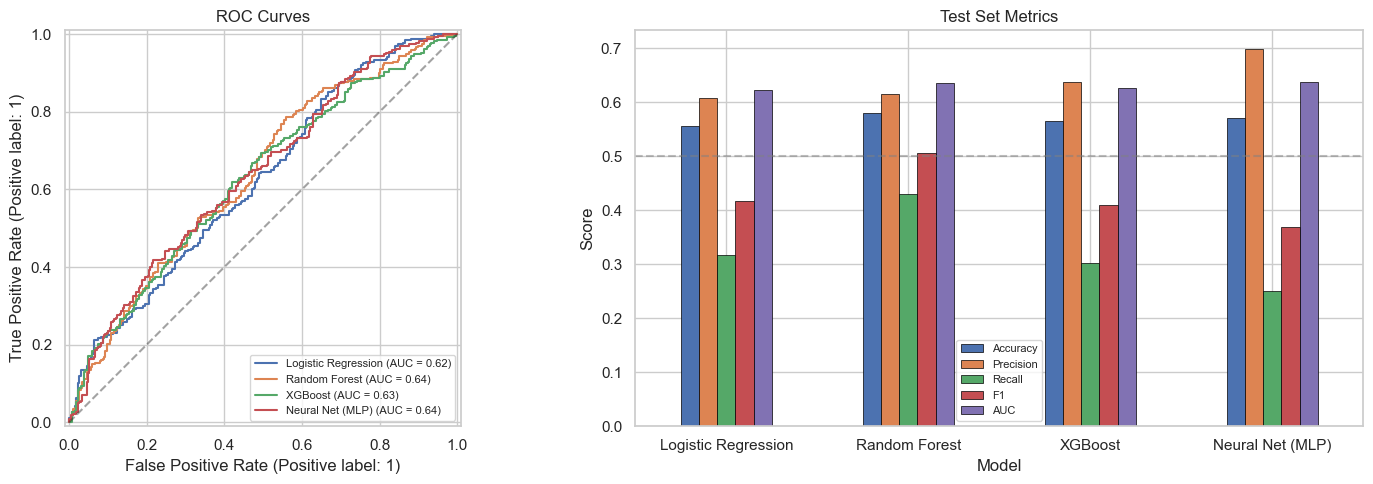

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC curves
ax = axes[0]
for name, prob in probs.items():
    RocCurveDisplay.from_predictions(y_test, prob, name=name, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
ax.set_title('ROC Curves')
ax.legend(fontsize=8, loc='lower right')

# Metric comparison
ax = axes[1]
test_df[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].plot(kind='bar', ax=ax, rot=0, edgecolor='black', lw=0.5)
ax.axhline(0.5, color='grey', ls='--', alpha=0.5)
ax.set_title('Test Set Metrics')
ax.set_ylabel('Score')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

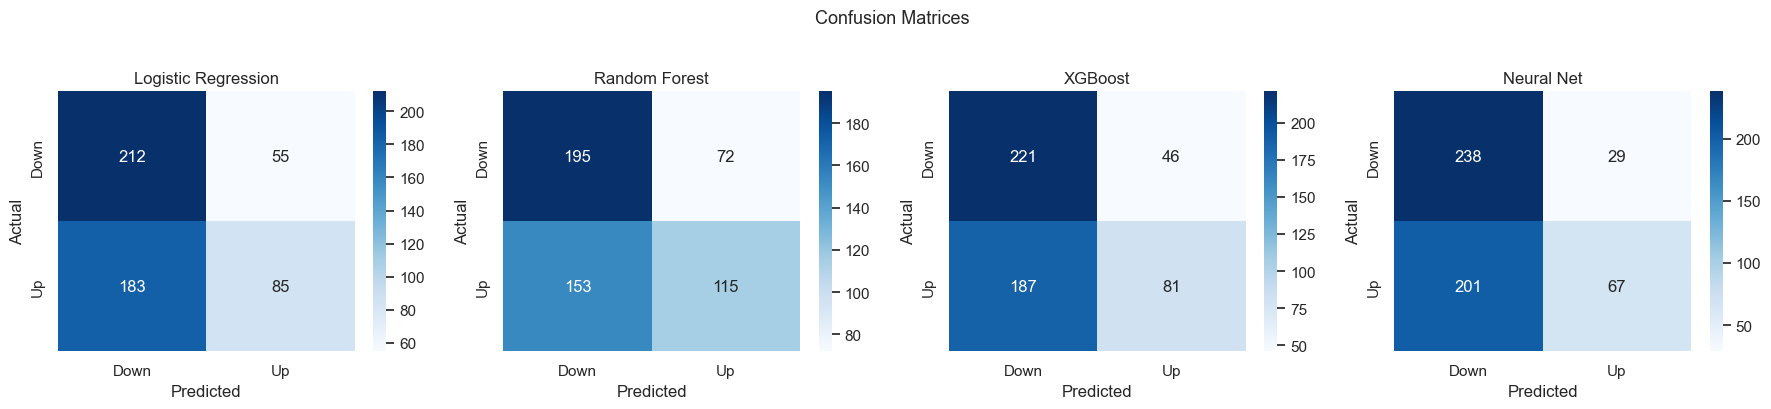

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for ax, (name, pred) in zip(axes, preds.items()):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    ax.set_title(f'{name.split("(")[0].strip()}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.suptitle('Confusion Matrices', y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

## 6. Feature Importance

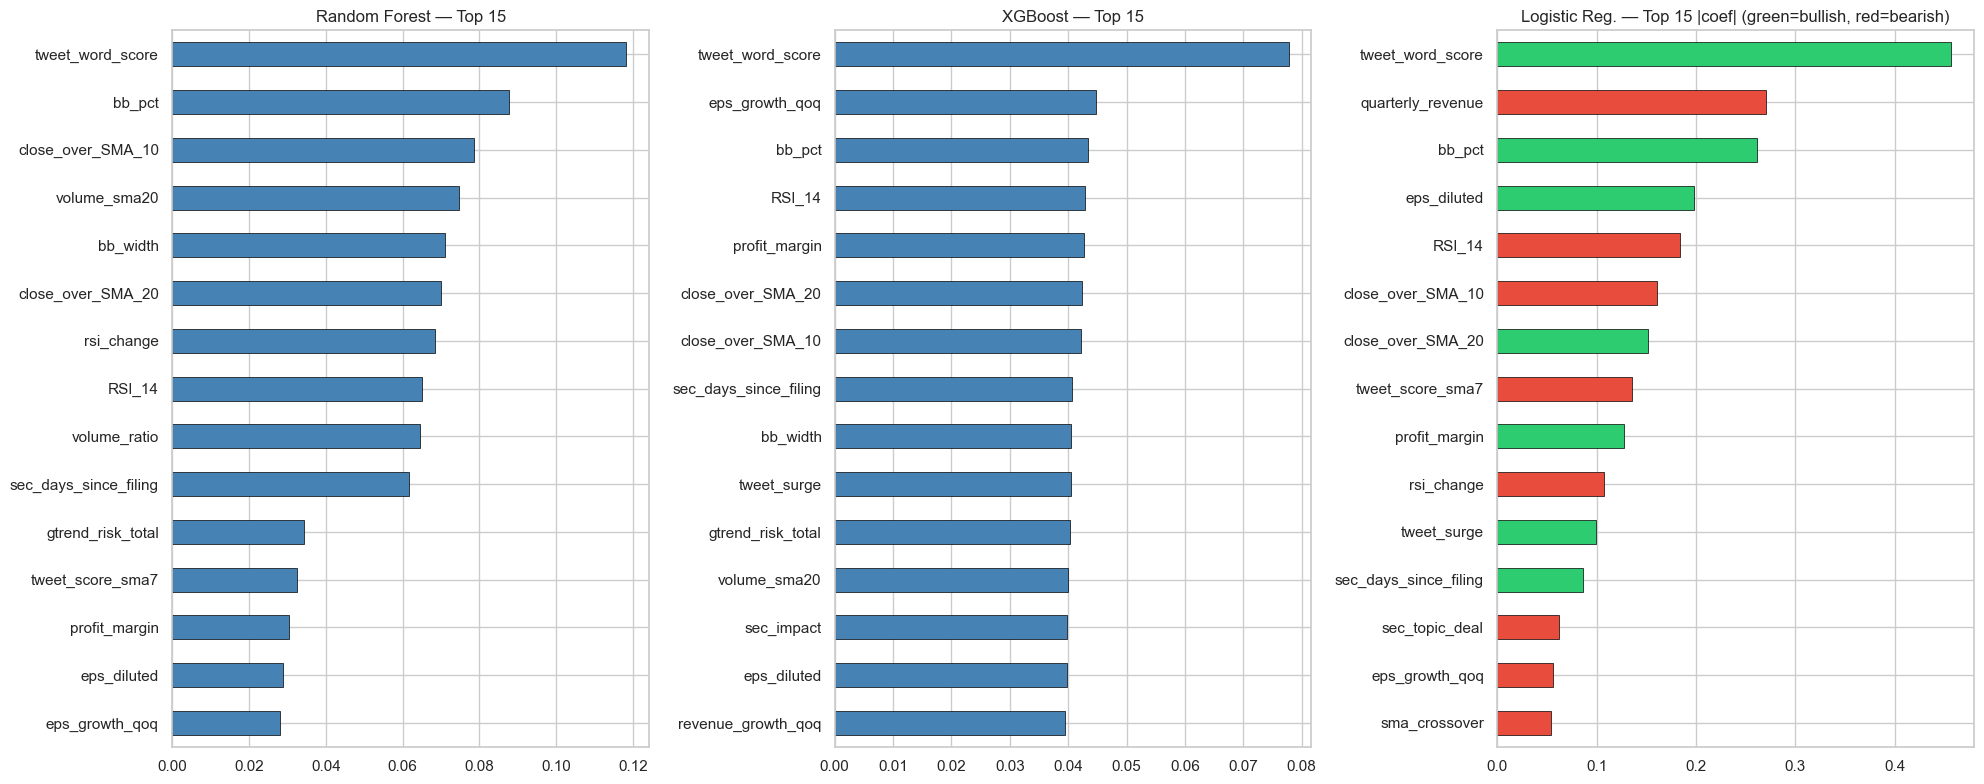

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# RF & XGBoost importances
for ax, (name, key) in zip(axes[:2], [('Random Forest', 'Random Forest'), ('XGBoost', 'XGBoost')]):
    imp = pd.Series(fitted[key].feature_importances_, index=feature_cols).sort_values()
    imp.tail(15).plot(kind='barh', ax=ax, color='steelblue', edgecolor='black', lw=0.5)
    ax.set_title(f'{name} — Top 15')

# LR coefficients
lr_coef = pd.Series(fitted['Logistic Regression'].coef_[0], index=feature_cols)
top15 = lr_coef.abs().sort_values().tail(15)
colors = ['#2ecc71' if lr_coef[c] > 0 else '#e74c3c' for c in top15.index]
top15.plot(kind='barh', ax=axes[2], color=colors, edgecolor='black', lw=0.5)
axes[2].set_title('Logistic Reg. — Top 15 |coef| (green=bullish, red=bearish)')

plt.tight_layout()
plt.show()

## 7. Rolling Accuracy

60-day rolling window to check for regime-dependent performance.

A rolling window lets us check if models perform consistently or only in certain market regimes.

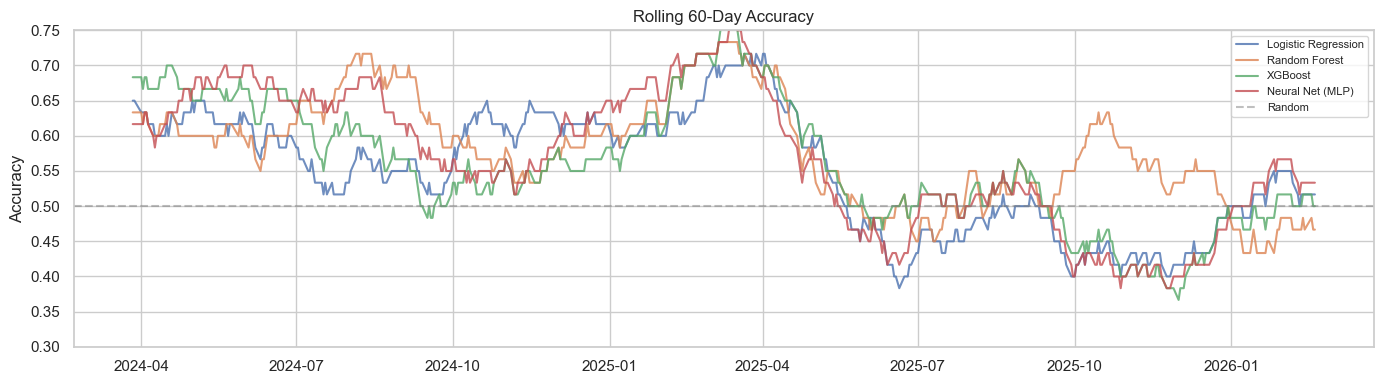

In [16]:
fig, ax = plt.subplots(figsize=(14, 4))
for name, pred in preds.items():
    correct = pd.Series((pred == y_test.values).astype(int), index=y_test.index)
    ax.plot(correct.rolling(60).mean(), label=name, alpha=0.8, lw=1.5)
ax.axhline(0.5, color='grey', ls='--', alpha=0.5, label='Random')
ax.set_title('Rolling 60-Day Accuracy')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.3, 0.75)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 8. Summary

In [17]:
best_f1 = tuned_df['F1'].idxmax()
best_auc = tuned_df['AUC'].idxmax()
baseline = max(y_test.mean(), 1 - y_test.mean())

print(f'Best tuned model by F1:   {best_f1} ({tuned_df.loc[best_f1, "F1"]:.3f})')
print(f'Best tuned model by AUC:  {best_auc} ({tuned_df.loc[best_auc, "AUC"]:.3f})')
print(f'Baseline accuracy:        {baseline:.3f}')
print()
print('Hyperparameter tuning results compared to default parameters above.')
print('Next step: backtesting to test if predictions translate to a trading edge.')

Best tuned model by F1:   Neural Net (MLP) (0.514)
Best tuned model by AUC:  Logistic Regression (0.650)
Baseline accuracy:        0.501

Hyperparameter tuning results compared to default parameters above.
Next step: backtesting to test if predictions translate to a trading edge.
